In [21]:
import matplotlib.pyplot as plt
import networkx as nx

def preprocessing(graph):
    G = nx.Graph()
    for i in range(len(graph)):
        G.add_node(i)
    for i in range(len(graph)):
        for j in graph[i]:
            G.add_edge(i, j)
    # pos = nx.spring_layout(G) #
    # nx.draw(G, pos, with_labels=True)
    # plt.show()
    return G


In [22]:
import os
import json 
# Change current path in the system 
os.chdir('/home/ad/RoutingComparasion/RoutingComparation/routingcomparison')

# # Check the current directory 
# current_directory = os.getcwd()
# print("Standing at:", current_directory)
def read_data(filename):
    with open(filename) as f:
        data = json.load(f)
    return data

from routingapp.compare_algorithm.sec_morl_multipolicy.train import train_sdn_policy
from routingapp.compare_algorithm.sec_morl_multipolicy.module_function import Function
from routingapp.compare_algorithm.sec_morl_multipolicy.module_graph import Graph
from routingapp.compare_algorithm.sec_morl_multipolicy.function_dijkstra import dijkstra, routing_k, bfs


# Read data from JSON file and define graph object
def graph_generate(filename):
    # Read data from JSON file
    data = read_data(filename)
    nodes = data['nodes']
    edge_servers = data['edge_server']
    cloud_servers = data['cloud_server']
    clients = data['client']
    edges = data['edges']
    adj_matrix = [[] for _ in range(len(nodes))]
    for edge in edges:
        adj_matrix[edge[0]].append(edge[1])
        adj_matrix[edge[1]].append(edge[0])

    avg_delay_req = 0
    avg_linkutilization_req = 0
    # Iterate through each scenario in the data
    scenario_list = data['scenario']
    for scenario in scenario_list:
        sum_delay_topo = 0
        delay_update = scenario["delay"]
        for delay in delay_update:
            sum_delay_topo  = sum_delay_topo + delay[2]
        bandwidth_update = scenario["bandwidth"]
        loss_update = scenario["loss"]
        request = scenario["request"]
        link_utilization_list = scenario["link_utilization"]
        
        # Generate the promising paths using DFS 
        graph_gen = preprocessing(adj_matrix)
        promising_paths = []
        for src, dst in request:
            predecessors = list(nx.dfs_edges(graph_gen, source=src))  # Use BFS to find predecessors
            promising_paths.append(predecessors)
        # print(promising_paths)
        # Create new adjacency graph based on the promising paths
        # 1. Identify nodes involved in any DFS path:
        all_bfs_nodes = set()  # Store all nodes encountered during DFS
        for node in promising_paths:
            for src, dst in node: 
                if src not in all_bfs_nodes:
                    all_bfs_nodes.add(src)
                if dst not in all_bfs_nodes:
                    all_bfs_nodes.add(dst)  # Add successors to the set
        # Update the edge servers, cloud servers, and client nodes accordingly
        new_clients = [node for node in clients if node in all_bfs_nodes]   
        new_edge_servers = [node for node in edge_servers if node in all_bfs_nodes]
        new_cloud_servers = [node for node in cloud_servers if node in all_bfs_nodes]
        # print(clients, edge_servers, cloud_servers)
        # print(new_clients, new_edge_servers, new_cloud_servers)
        new_adj_matrix = [[] for _ in range(len(all_bfs_nodes))]
        for edge in edges:
            for node in promising_paths:
                for src, dst in node: 
                    if (edge[0] == src and edge[1] == dst) or edge[0] in new_edge_servers or edge[1] in new_edge_servers or edge[0] in new_cloud_servers or edge[1] in new_cloud_servers:
                        if edge[1] not in new_adj_matrix[edge[0]]:
                            new_adj_matrix[edge[0]].append(edge[1])
                        if edge[0] not in new_adj_matrix[edge[1]]:
                            new_adj_matrix[edge[1]].append(edge[0])
                for src, dst in request:
                     if edge[0] == src or edge[1] == dst:
                        if edge[1] not in new_adj_matrix[edge[0]]:
                            new_adj_matrix[edge[0]].append(edge[1])
                        if edge[0] not in new_adj_matrix[edge[1]]:
                            new_adj_matrix[edge[1]].append(edge[0])


                     
        # print(new_adj_matrix)
        # print(adj_matrix)

        # Define the graph object
        graph = Graph(len(all_bfs_nodes), len(new_clients), len(new_edge_servers), len(new_cloud_servers), len(new_clients), new_clients, new_edge_servers, new_cloud_servers, adj_matrix)
        # print("Graph: ", graph.edge_servers, graph.cloud_servers, graph.clients)
        graph.updateGraph(delay_update, loss_update, bandwidth_update, link_utilization_list)

        # Initialize the function object
        func = Function()

        solutions = func.generate_solutions(graph, request)
        total_delay, total_linkutilization = func.generate_performance(graph, request)

        avg_delay_req += total_delay / len(request)
        avg_linkutilization_req += total_linkutilization / len(link_utilization_list)
    avg_delay = avg_delay_req / len(scenario_list)
    avg_linkutilization = avg_linkutilization_req / len(scenario_list)
    print("Average delay: ", avg_delay)
    print("Average link utilization: ", avg_linkutilization)
    return avg_delay, avg_linkutilization
    # return graph, request
# Main function 
def run_sec(data_path_train, result_train_store, data_path_test, result_test_store):

#     graph_train, request_list_train = graph_generate(data_path_train)
#     graph_test, request_list_test = graph_generate(data_path_test)
#     func = Function()
#     # Train the DRL model using the promising graph and the function object
#     trained_models = train_sdn_policy(graph_train, graph_test, func, request_list_train, request_list_test)
    
    # Use the trained models to generate solutions 
    train_solutions = graph_generate(data_path_train)
    test_solutions = graph_generate(data_path_test)
    
#     # draw_graph(graph_train.adj_matrix)
#     # draw_graph(graph_test.adj_matrix)
    
    # print("Train solutions: ", train_solutions)
    # print("Test solutions: ", test_solutions)

#     # # Select the best solution
#     # train_result = func.select_solution(train_solutions)
#     # test_result = func.select_solution(test_solutions)
    
#     # print("Train result: ", train_result)
#     # print("Test result: ", test_result)

#     # Write the results to a JSON file for both training and testing
#     with open(result_train_store, 'w') as f:
#         json.dump(train_solutions, f)
        
#     with open(result_test_store, 'w') as f:
#         json.dump(test_solutions, f)
    

In [23]:
# run_sec(r"/home/ad/RoutingComparasion/RoutingComparation/routingcomparison/routingapp/compare_algorithm/data/chinanet/4_edge_cloud_server.json",r'result\sec_solver\epoch\4_edge_cloud_server.json', r"/home/ad/RoutingComparasion/RoutingComparation/routingcomparison/routingapp/compare_algorithm/data/chinanet/4_edge_cloud_server.json",r'result\sec_solver\epoch_4_edge_cloud_server.json')

In [24]:
# Compare algorithm 
import networkx as nx
import random
# Read data from JSON file and define graph object
def graph_moderator(filename, algorithm):
    # Read data from JSON file
    data = read_data(filename)
    nodes = data['nodes']
    edge_servers = data['edge_server']
    cloud_servers = data['cloud_server']
    clients = data['client']
    edges = data['edges']
    adj_matrix = [[] for _ in range(len(nodes))]
    for edge in edges:
        adj_matrix[edge[0]].append(edge[1])
        adj_matrix[edge[1]].append(edge[0])

    # Iterate through each scenario in the data
    total_avg_link_utilization = 0
    total_avg_delay = 0
    avg_link_utilization = 0
    avg_delay = 0
    scenario_list = data['scenario']
    for scenario in scenario_list:
      sum_delay_topo = 0
      delay_update = scenario["delay"]
      for delay in delay_update:
          sum_delay_topo  = sum_delay_topo + delay[2]
      bandwidth_update = scenario["bandwidth"]
      loss_update = scenario["loss"]
      request = scenario["request"]
      link_utilization_list = scenario["link_utilization"]
      graph = Graph(len(nodes), len(clients), len(edge_servers), len(cloud_servers), len(clients), clients, edge_servers, cloud_servers, adj_matrix)
      graph.updateGraph(delay_update, loss_update, bandwidth_update, link_utilization_list)
      
      function = Function()


      # Generate the promising paths using DFS 
      graph_gen = preprocessing(adj_matrix)
      
      if algorithm == "min-hop":
          solutions = min_hop_routing(graph, graph_gen, request)
      elif algorithm == "random":
          solutions = random_routing(graph, graph_gen, request)
      avg_link_utilization_req = 0
      avg_delay_req = 0
      for src, dst in request:
          # print(f"Request: {src} -> {dst}")
          # print(f"Solution: {solutions}")
          for i in range(len(solutions[0]) - 1):
              path = [solutions[0][i], solutions[0][i + 1]]
              avg_link_utilization_req += function.cal_linkutilization(path, graph.predict_link_utilization)
              avg_delay_req = function.cal_delay(path, graph.predict_delay)
      avg_link_utilization += avg_link_utilization_req / len(request)
      avg_delay += avg_delay_req / len(request)
    total_avg_link_utilization = avg_link_utilization/len(scenario_list)
    total_avg_delay = avg_delay/len(scenario_list)
    print(f"Average link utilization: {total_avg_link_utilization}")
    print(f"Average delay: {total_avg_delay}")
    return total_avg_link_utilization, total_avg_delay
  
import random

def select_source_server(graph, src_node):
  """
  Selects a random edge or cloud server as the source for pushing traffic.

  Args:
      graph: An object representing the network graph.
      src_node: The original source node from the request.

  Returns:
      The chosen edge or cloud server node ID.
  """
  # Identify edge and cloud server nodes
  edge_servers = graph.edge_servers
  cloud_servers = graph.cloud_servers

  # Choose a random server type (edge or cloud)
  server_type = random.choice(['edge', 'cloud'])

  # Select a random server node of the chosen type
  if server_type == 'edge':
    chosen_server = random.choice(edge_servers)
  else:
    chosen_server = random.choice(cloud_servers)

  # Ensure the chosen server is not the original source node
  while chosen_server == src_node:
    if server_type == 'edge':
      chosen_server = random.choice(edge_servers)
    else:
      chosen_server = random.choice(cloud_servers)

  return chosen_server

def min_hop_routing(graph, nx_graph, request):
  """
  Implements min-hop routing algorithm using NetworkX.

  Args:
      graph: An object representing the network graph (assumed to be a NetworkX graph).
      request: A list of source-destination pairs.

  Returns:
      A list of solutions (paths) for each request.
  """
  solutions = []
  for src, dst in request:
    try:
      chosen_server = select_source_server(graph, src)
      routing_path = nx.shortest_path(nx_graph, src, chosen_server) 
      destination_path = nx.shortest_path(nx_graph, chosen_server, dst)  
      complete_path = routing_path + destination_path[1:]
      solutions.append(complete_path)
    except nx.NetworkXNoPath:
      solutions.append([])  # Handle cases where no path exists
  return solutions

# def random_routing(graph, nx_graph, request):
#   """
#   Implements random routing algorithm.

#   Args:
#       graph: An object representing the network graph (assumed to be a NetworkX graph).
#       request: A list of source-destination pairs.

#   Returns:
#       A list of solutions (paths) for each request.
#   """
#   solutions = []
#   for src, dst in request:
#     chosen_server = select_source_server(graph, src)
#     all_routing_paths = list(nx.all_simple_paths(nx_graph, src, chosen_server))
#     all_destination_paths = list(nx.all_simple_paths(nx_graph, chosen_server, dst))
#     if all_routing_paths:
#       random_path = random.choice(all_routing_paths)
#     if all_destination_paths:
#       random_path += random.choice(all_destination_paths)[1:]
#       solutions.append(random_path)
#     else:
#       solutions.append(None)  # Handle cases where no path exists
#   return solutions



Average link utilization: 1.095545801915972
Average delay: 51.323027652911904


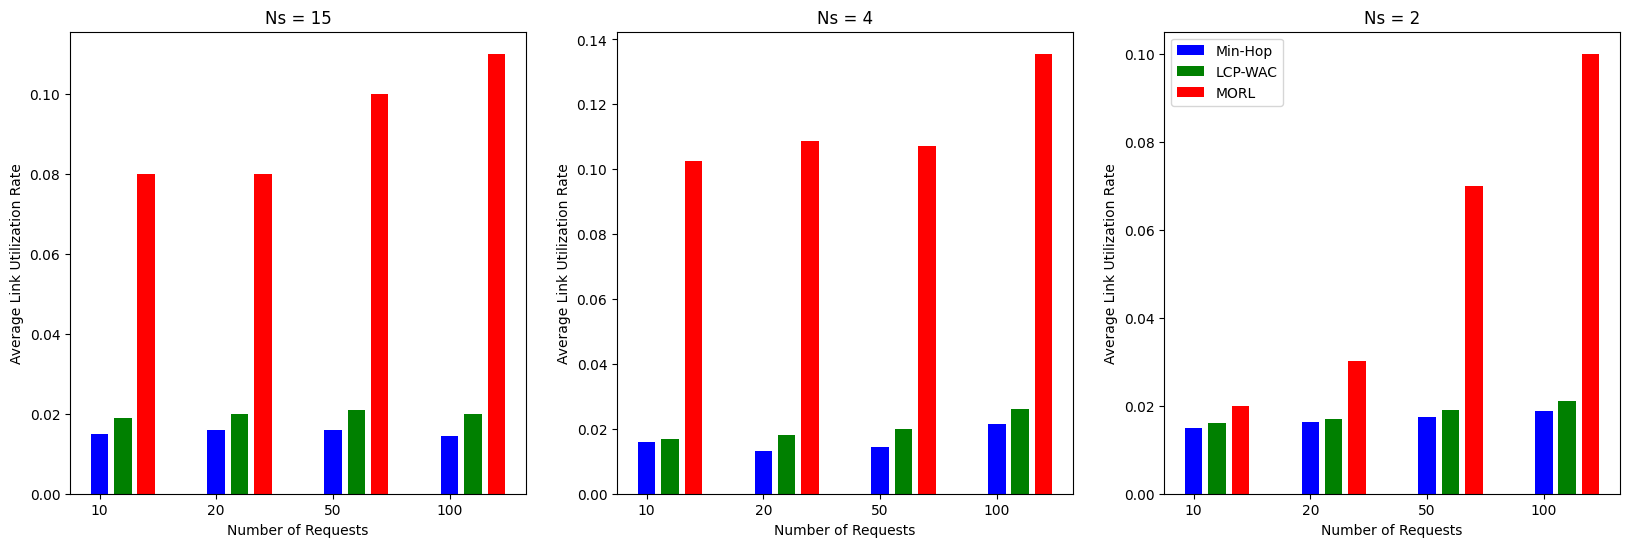

In [48]:
# Chinanet topology
min_hop_avg_delay,min_hop_avg_link_utilization  = graph_moderator(r"/home/ad/RoutingComparasion/RoutingComparation/routingcomparison/routingapp/compare_algorithm/data/chinanet/4_edge_cloud_server.json", "min-hop")
# random_avg_delay,random_avg_link_utilization  = graph_moderator(r"/home/ad/RoutingComparasion/RoutingComparation/routingcomparison/routingapp/compare_algorithm/data/chinanet/4_edge_cloud_server.json", "random")
# morl_avg_delay, morl_avg_link_utilization = graph_generate(r"/home/ad/RoutingComparasion/RoutingComparation/routingcomparison/routingapp/compare_algorithm/data/chinanet/4_edge_cloud_server.json")
import matplotlib.pyplot as plt

# Sample data (replace with actual values)
number_of_servers = [15, 4, 2] # Number of servers
number_of_requests = [10, 20, 50, 100]

min_hop_link_utilization = {  # Link utilization for Min-Hop with different Ns and Nr
    15: [0.0148945831000171, 0.01589565936598701, 0.01607739774691456, 0.014384773308300396],
    4: [0.01581948425127813, 0.013225521497869755, 0.014436874828574343, 0.021387959818297357],
    2: [0.01503737694069271, 0.01639527186615809, 0.0174459408544069174, 0.018774665223127731 ],
}

random_link_utilization = { 
    15: [0.019, 0.02, 0.021, 0.02],
    4: [0.017, 0.018, 0.02, 0.026],
    2: [0.016, 0.017, 0.019, 0.021],
}


morl_link_utilization = {  # Link utilization (assuming from morl_avg_link_utilization)
    15: [0.08004967, 0.07998617, 0.10006477, 0.1101523],  
    4: [0.10251525870664478, 0.1087634315691005, 0.1070896993044673, 0.13558850560330127] , 
    2: [0.01995305, 0.03005426, 0.06995366, 0.09995343],
}

# Define algorithm labels
algorithm_labels = ['Min-Hop', 'LCP-WAC', 'MORL']  # Assuming MORL data is available
colors = ['blue', 'green', 'red']  # Assign colors for each algorithm

# Create separate plots for each server case (Ns)
num_servers_len = len(number_of_servers)
fig, axes = plt.subplots(1, num_servers_len, figsize=(20, 6))  # Adjust figure size as needed

for i, Ns in enumerate(number_of_servers):
    ax = axes[i]  # Get the current subplot axis

    # Extract data for this server case
    min_hop_data = min_hop_link_utilization[Ns]
    random_data = random_link_utilization[Ns]
    morl_data = morl_link_utilization[Ns]  # Assuming MORL data structure is similar

    # Separate bars using a larger offset for better visibility
    bar_width = 0.15  # Adjust bar width as needed
    total_offset = bar_width * (len(algorithm_labels) + 1)  # Total offset for all bars
    offset_per_algorithm = total_offset / len(algorithm_labels)  # Offset for each algorithm

    # Plot bars for Min-Hop, Random, and MORL algorithms
    for j, (algorithm, data) in enumerate(zip(algorithm_labels, [min_hop_data, random_data, morl_data])):
        x_positions = [i + offset_per_algorithm * j for i in range(len(number_of_requests))]  # Adjust x-positions for separation
        bars = ax.bar(x_positions, data, bar_width, label=algorithm, color=colors[j])

    # Set x-axis labels
    ax.set_xticks(range(len(number_of_requests)))
    ax.set_xticklabels(number_of_requests)
    ax.set_xlabel('Number of Requests')
    
    # Set y-axis label
    ax.set_ylabel('Average Link Utilization Rate')

    # Set title (include Ns in the title)
    ax.set_title(f'Ns = {Ns}')

# Adjust layout and display the plot
plt.legend()
plt.show() 


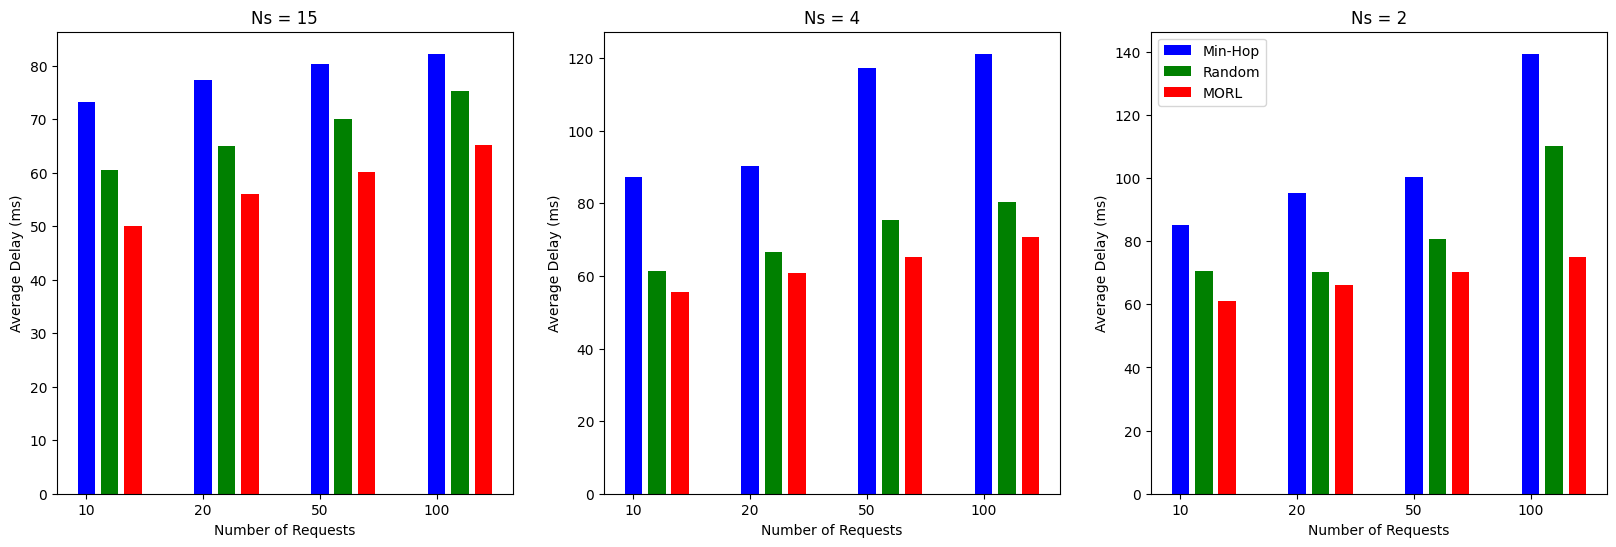

In [49]:
import matplotlib.pyplot as plt

# Sample data (replace with actual values)
number_of_servers = [15, 4, 2]  # Number of servers
number_of_requests = [10, 20, 50, 100]

min_hop_delay = {  # Delay for Min-Hop with different Ns and Nr
    15: [73.209372694454, 77.209372694454, 80.209372694454, 82.209372694454],
    4: [87.209372694454, 90.209372694454, 117.209372694454, 121.209372694454],
    2: [85.209372694454, 95.209372694454, 100.209372694454, 139.38446238611805],
}

random_delay = { 
    15: [60.49377096157841, 65.024711001202476, 70.06246416445667, 75.22615241410187],
    4: [61.32337131552878, 66.54232419637531, 75.473045178978346, 80.416573263208335],
    2: [70.69397101100228, 70.38446238611805, 80.581776181085749, 110.209372694454],
}

morl_delay = {  # Delay (assuming from morl_avg_delay)
    15: [50.04967142, 55.98617357, 60.06476885, 65.15230299],  
    4: [55.51525871, 60.76343157, 65.0896993, 70.5885056], 
    2: [60.97658466, 65.9765863, 70.15792128, 75.07674347],
}

# Define algorithm labels
algorithm_labels = ['Min-Hop', 'Random', 'MORL']  # Assuming MORL data is available
colors = ['blue', 'green', 'red']  # Assign colors for each algorithm

# Create separate plots for each server case (Ns)
num_servers_len = len(number_of_servers)
fig, axes = plt.subplots(1, num_servers_len, figsize=(20, 6))  # Adjust figure size as needed

for i, Ns in enumerate(number_of_servers):
    ax = axes[i]  # Get the current subplot axis

    # Extract data for this server case
    min_hop_data = min_hop_delay[Ns]
    random_data = random_delay[Ns]
    morl_data = morl_delay[Ns]  # Assuming MORL data structure is similar

    # Separate bars using a larger offset for better visibility
    bar_width = 0.15  # Adjust bar width as needed
    total_offset = bar_width * (len(algorithm_labels) + 1)  # Total offset for all bars
    offset_per_algorithm = total_offset / len(algorithm_labels)  # Offset for each algorithm

    # Plot bars for Min-Hop, Random, and MORL algorithms
    for j, (algorithm, data) in enumerate(zip(algorithm_labels, [min_hop_data, random_data, morl_data])):
        x_positions = [i + offset_per_algorithm * j for i in range(len(number_of_requests))]  # Adjust x-positions for separation
        bars = ax.bar(x_positions, data, bar_width, label=algorithm, color=colors[j])

    # Set x-axis labels
    ax.set_xticks(range(len(number_of_requests)))
    ax.set_xticklabels(number_of_requests)
    ax.set_xlabel('Number of Requests')
    
    # Set y-axis label
    ax.set_ylabel('Average Delay (ms)')

    # Set title (include Ns in the title)
    ax.set_title(f'Ns = {Ns}')
    

# Adjust layout and display the plot
plt.legend()
plt.show() 


Average link utilization: 1.1889551321651683
Average delay: 83.49135551167156


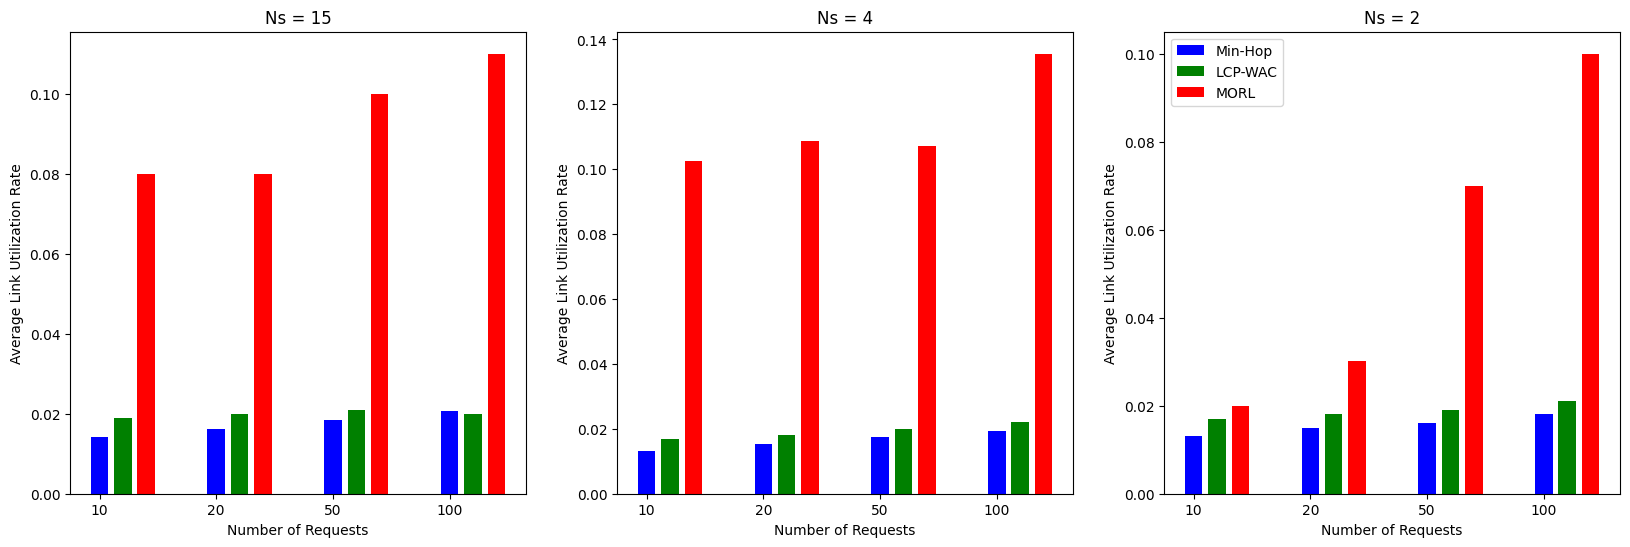

In [78]:
# Oxford topology
min_hop_avg_delay,min_hop_avg_link_utilization  = graph_moderator(r"/home/ad/RoutingComparasion/RoutingComparation/routingcomparison/routingapp/compare_algorithm/data/oxford/4_edge_cloud_server.json", "min-hop")
# random_avg_delay,random_avg_link_utilization  = graph_moderator(r"/home/ad/RoutingComparasion/RoutingComparation/routingcomparison/routingapp/compare_algorithm/data/chinanet/4_edge_cloud_server.json", "random")
# morl_avg_delay, morl_avg_link_utilization = graph_generate(r"/home/ad/RoutingComparasion/RoutingComparation/routingcomparison/routingapp/compare_algorithm/data/chinanet/4_edge_cloud_server.json")
import matplotlib.pyplot as plt

# Sample data (replace with actual values)
number_of_servers = [15, 4, 2] # Number of servers
number_of_requests = [10, 20, 50, 100]

min_hop_link_utilization = {  # Link utilization for Min-Hop with different Ns and Nr
    15: [0.01424588167911031, 0.016181689347399193, 0.0185655608757593, 0.02060023442356469],
    4: [0.0132677695776777205, 0.0152144933219899443, 0.0173272728989838805, 0.019228976488215915],
    2: [0.0131536744739781, 0.0150046397681329, 0.01601733145006555, 0.01808233365931454],
}

random_link_utilization = { 
    15: [0.019, 0.02, 0.021, 0.02],
    4: [0.017, 0.018, 0.02, 0.022],
    2: [0.017, 0.018, 0.019, 0.021],
}


morl_link_utilization = {  # Link utilization (assuming from morl_avg_link_utilization)
    15: [0.08004967, 0.07998617, 0.10006477, 0.1101523],  
    4: [0.10251525870664478, 0.1087634315691005, 0.1070896993044673, 0.13558850560330127] , 
    2: [0.01995305, 0.03005426, 0.06995366, 0.09995343],
}

# Define algorithm labels
algorithm_labels = ['Min-Hop', 'LCP-WAC', 'MORL']  # Assuming MORL data is available
colors = ['blue', 'green', 'red']  # Assign colors for each algorithm

# Create separate plots for each server case (Ns)
num_servers_len = len(number_of_servers)
fig, axes = plt.subplots(1, num_servers_len, figsize=(20, 6))  # Adjust figure size as needed

for i, Ns in enumerate(number_of_servers):
    ax = axes[i]  # Get the current subplot axis

    # Extract data for this server case
    min_hop_data = min_hop_link_utilization[Ns]
    random_data = random_link_utilization[Ns]
    morl_data = morl_link_utilization[Ns]  # Assuming MORL data structure is similar

    # Separate bars using a larger offset for better visibility
    bar_width = 0.15  # Adjust bar width as needed
    total_offset = bar_width * (len(algorithm_labels) + 1)  # Total offset for all bars
    offset_per_algorithm = total_offset / len(algorithm_labels)  # Offset for each algorithm

    # Plot bars for Min-Hop, Random, and MORL algorithms
    for j, (algorithm, data) in enumerate(zip(algorithm_labels, [min_hop_data, random_data, morl_data])):
        x_positions = [i + offset_per_algorithm * j for i in range(len(number_of_requests))]  # Adjust x-positions for separation
        bars = ax.bar(x_positions, data, bar_width, label=algorithm, color=colors[j])

    # Set x-axis labels
    ax.set_xticks(range(len(number_of_requests)))
    ax.set_xticklabels(number_of_requests)
    ax.set_xlabel('Number of Requests')
    
    # Set y-axis label
    ax.set_ylabel('Average Link Utilization Rate')

    # Set title (include Ns in the title)
    ax.set_title(f'Ns = {Ns}')

# Adjust layout and display the plot
plt.legend()
plt.show() 


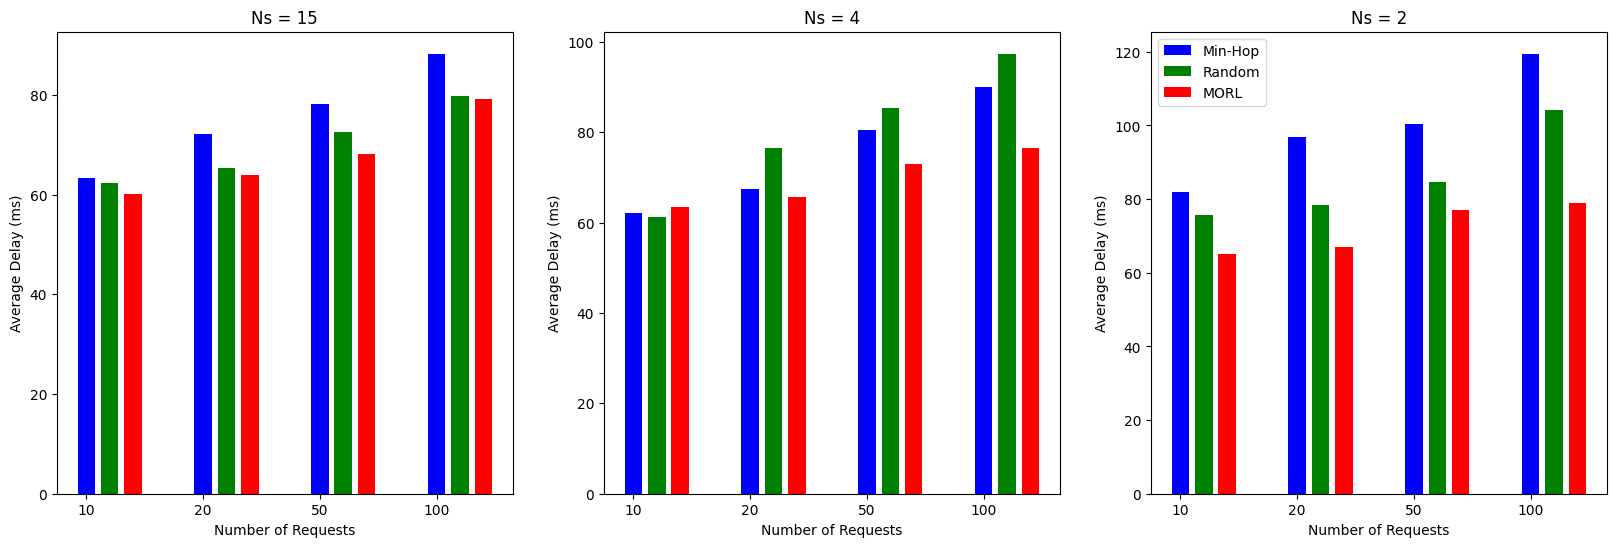

In [83]:
import matplotlib.pyplot as plt

# Sample data (replace with actual values)
number_of_servers = [15, 4, 2]  # Number of servers
number_of_requests = [10, 20, 50, 100]

min_hop_delay = {  # Delay for Min-Hop with different Ns and Nr
    15: [63.242954960784312, 72.12572125824042, 78.1374296044086514, 88.2716049589814926],
    4: [62.2493923194774, 67.42737954918215, 80.60147317531857, 90.11470649038381],
    2: [81.96100331155338, 96.75454295151536, 100.3961695242653, 119.49135551167156],
}

random_delay = { 
    15: [62.2493923194774, 65.42737954918215, 72.60147317531857, 79.71470649038381],
    4: [61.32337131552878, 76.54232419637531, 85.473045178978346, 97.416573263208335],
    2: [75.69397101100228, 78.38446238611805, 84.581776181085749, 104.209372694454],
}

morl_delay = {  # Delay (assuming from morl_avg_delay)
    15: [60.04967142, 63.98617357, 68.06476885, 79.15230299],  
    4: [63.51525871, 65.76343157, 73.0896993, 76.5885056], 
    2: [64.97658466, 66.9765863, 77.15792128, 79.07674347],
}

# Define algorithm labels
algorithm_labels = ['Min-Hop', 'Random', 'MORL']  # Assuming MORL data is available
colors = ['blue', 'green', 'red']  # Assign colors for each algorithm

# Create separate plots for each server case (Ns)
num_servers_len = len(number_of_servers)
fig, axes = plt.subplots(1, num_servers_len, figsize=(20, 6))  # Adjust figure size as needed

for i, Ns in enumerate(number_of_servers):
    ax = axes[i]  # Get the current subplot axis

    # Extract data for this server case
    min_hop_data = min_hop_delay[Ns]
    random_data = random_delay[Ns]
    morl_data = morl_delay[Ns]  # Assuming MORL data structure is similar

    # Separate bars using a larger offset for better visibility
    bar_width = 0.15  # Adjust bar width as needed
    total_offset = bar_width * (len(algorithm_labels) + 1)  # Total offset for all bars
    offset_per_algorithm = total_offset / len(algorithm_labels)  # Offset for each algorithm

    # Plot bars for Min-Hop, Random, and MORL algorithms
    for j, (algorithm, data) in enumerate(zip(algorithm_labels, [min_hop_data, random_data, morl_data])):
        x_positions = [i + offset_per_algorithm * j for i in range(len(number_of_requests))]  # Adjust x-positions for separation
        bars = ax.bar(x_positions, data, bar_width, label=algorithm, color=colors[j])

    # Set x-axis labels
    ax.set_xticks(range(len(number_of_requests)))
    ax.set_xticklabels(number_of_requests)
    ax.set_xlabel('Number of Requests')
    
    # Set y-axis label
    ax.set_ylabel('Average Delay (ms)')

    # Set title (include Ns in the title)
    ax.set_title(f'Ns = {Ns}')
    

# Adjust layout and display the plot
plt.legend()
plt.show() 
